# Prediction of risk factors for stroke using classification algorithms
## PyConIE 2018

<img src="met.png">



## Abstract:

Atrial fibrillation (AF) is the most common irregular heartbeat among the world’s population and is a major contributing factor to clot formation within the heart. When such a blood clot enters the cardiovascular system, it first must travel along the ascending aorta. The clot may travel along the aortic arch and travel towards the brain through the left and right common carotid arteries. If clot enters these vessels, it can become lodged within the smaller vessels of the brain and cause a stroke. We apply supervised machine learning classifiers (logit, CatBoost) for detecting stroke probability using simulation data. Various scenarios are implemented to examine the impact of variables such as shape of the aortic arch, varying clot dimensions and the entry point. Model selection tools (grid search, cross-validation) and classification probability are calculated for each classifier.

Defining concepts

## What is a stroke?

A stroke occurs when the blood supply to part of the brain is interrupted or reduced, depriving brain tissue of oxygen and nutrients. Within minutes, brain cells begin to die.

 - 20% of cases are caused by a rupture or leakage from a blood vessel;
 - 80% of cases are due to the formation of a blood clot in a vessel supplying blood to the brain (also known as a “ischemic stroke”).  
 
 We shall focus on cases due to a blood clot.

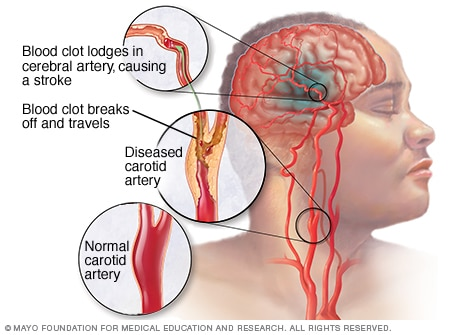

In [1084]:
from IPython.display import Image
Image(filename='../figs/ischemicstroke.jpg', width = 600, height=600)

## Stroke medical risk factors


Atrial fibrillation (AF) is the most common irregular heartbeat among the world’s population and is a major contributing factor to clot formation within the heart.


It can cause the blood to stop moving and coagulate causing a blood clot. 
It can then enter the aortic arch and has the possibility of travelling to the brain causing a stroke.




## What is artrial fibrillation (AF)?

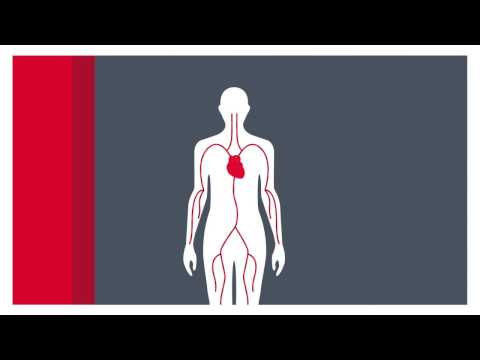

In [1085]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('QbMjLleZUQU', width=500, height=400, end=55.5)

A stroke is a medical emergency and prompt treatment is crucial. Early action can minimize brain damage and potential complications.

A stroke is a leading cause of disability which drains our economy.

2,000 people die in Ireland per annum as a result of accute Ishemic stroke (Irish Heart Foundation, 2017).

Therefore it is crucial to gain knowledge into the risk factors for strokes in order to minimise them.

## Objectives:

1. To investigate risk factors for strokes in simulated settings;
2. To apply supervised machine learning classifiers for detecting stroke;
3. To examine the impact of variables 
 - such as heartbeat;
 - shape of the aortic arch;
 - varying clot dimensions; 
 - the entry point.

## Description of simulation system



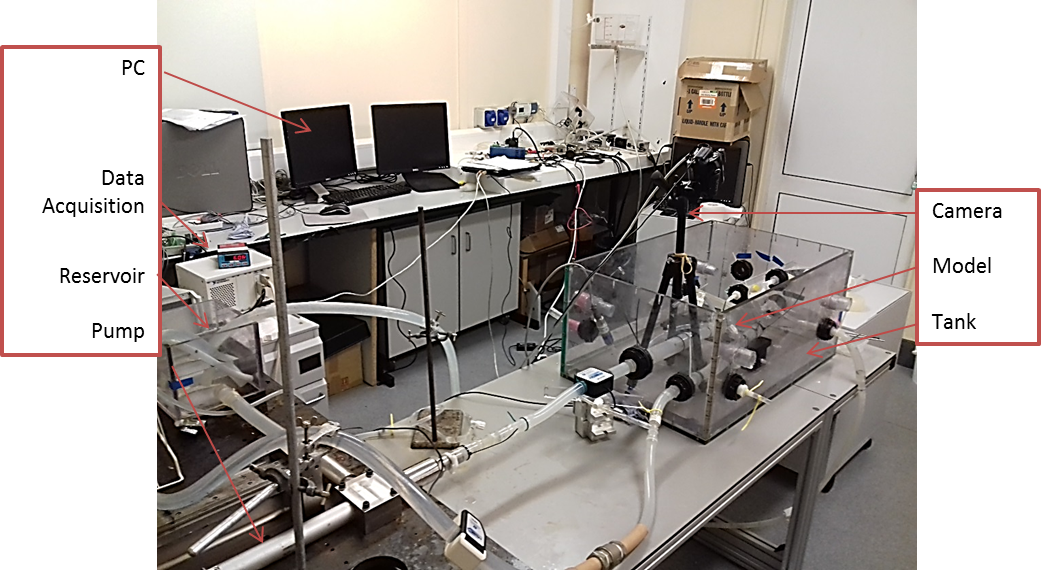

In [1086]:
Image(filename='../figs/GvSi8m.png', width = 800, height=600)



## Imports


In [1087]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
%matplotlib inline

# pip install seaborn 
import seaborn as sns

import sklearn
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split

from IPython.display import display
from IPython.display import Image

from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv

import warnings
warnings.filterwarnings('ignore')

In [1088]:
data = pd.read_csv('~/Documents/bloodclots/data/data.csv', index_col=0)
data.shape 

(1170, 8)

Data consist of 1170 released clots with 8 parameters.

### Features:

In [1089]:
sorted(list(data.columns))

['Arch',
 'Branch',
 'Diameter',
 'Entry',
 'Flowrate',
 'Length',
 'Rigid',
 'Thrombin']

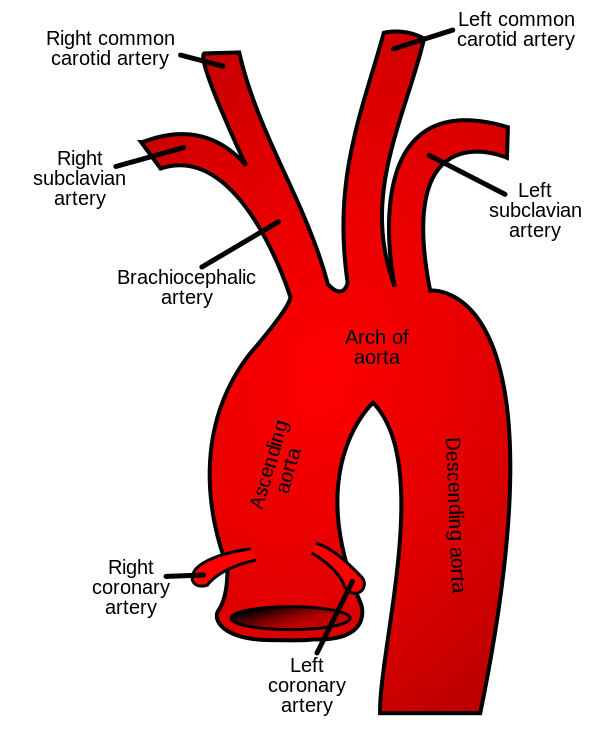

In [1090]:
Image(filename='../figs/ascendingaorta.png', width = 500, height=600)

### Arch

The aortic arch is the portion of the main artery that bends between the ascending and descending aorta. It leaves the heart and ascends, then descends back to create the arch.

Types of aortic arch:


In [1091]:
data.Arch.value_counts(normalize=True)

model1    0.538462
model2    0.153846
model3    0.153846
model4    0.153846
Name: Arch, dtype: float64

### Model manufacture

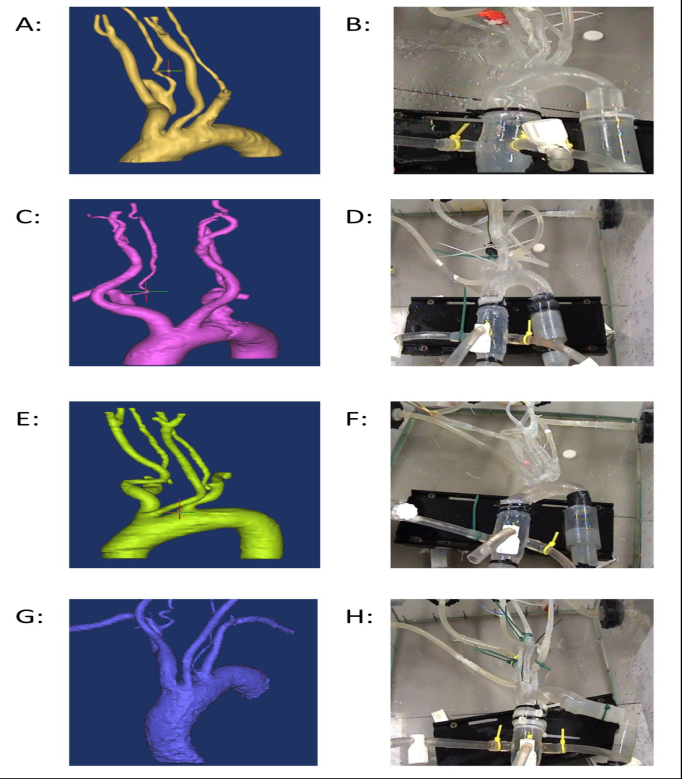

In [1092]:
Image(filename='../figs/OvOTun.png', width = 500, height=600)

From which Model 1 (Romanesque) is the most common (here and in reality).

### Branch

In [1093]:
list(data.Branch.unique())

['lcca', 'lsub', 'rcca', 'descending', 'rsub']

For the purpose of analysis branches are combined: 


In [1094]:
data['Head'] = data.Branch.map({'lcca':1, 
                        'rcca':1, 
                        'lsub':0, 
                        'rsub':0,
                        'descending':0
                       })


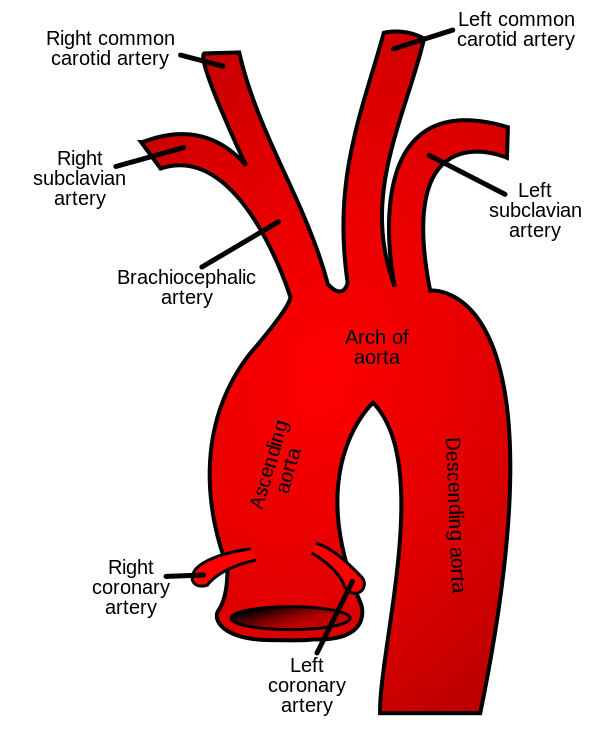

In [1095]:
Image(filename='../figs/ascendingaorta.png', width = 500, height=600)

Similated study shows that majority of released clots went through the descending branch


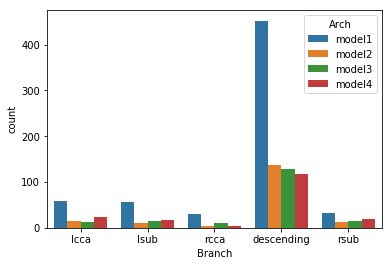

In [1096]:
sns.countplot(x='Branch', data=data, hue='Arch')

The majority of clots released went through the descending branch.

### Length

In [1097]:
cols = ['Length']
data.groupby(['Arch'])[cols].describe(percentiles=[])

Length                                         
        count       mean       std   min    50%    max
Arch                                                  
model1  630.0  10.316205  6.977261  2.77  7.485  38.48
model2  180.0   6.185667  1.622106  2.52  5.960  11.52
model3  180.0   5.843500  1.657902  3.26  5.585  11.88
model4  180.0   6.207722  1.862180  3.29  5.780  13.80

The majority of clots were released for Model 1, long clots were added manually.

Text(0.5,1,'Clots less than 10cm')

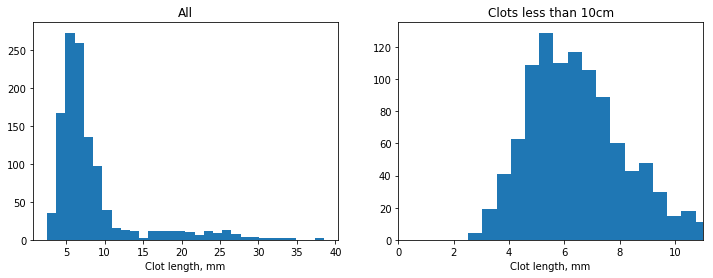

In [1098]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].hist(data.Length, 30)
axes[0].grid=True
axes[0].set_xlabel("Clot length, mm")
axes[0].set_title("All")
axes[1].hist(data.Length, 70)
axes[1].grid=True
axes[1].set_xlim([0,11])
axes[1].set_xlabel("Clot length, mm")
axes[1].set_title('Clots less than 10cm')

In [1099]:
data = data[data.Length<10]

To normalise distribution we eliminate blood clots above 10 cm 

In [1100]:
cols = ['Length']
data.groupby(['Branch'])[cols].describe(percentiles=[])

Length                                      
            count      mean       std   min   50%   max
Branch                                                 
descending  691.0  6.221865  1.564684  2.52  6.05  9.88
lcca         84.0  6.413929  1.530637  3.51  6.54  9.90
lsub         85.0  6.483647  1.588644  2.77  6.37  9.71
rcca         42.0  6.319524  1.521735  3.42  6.07  9.61
rsub         73.0  6.220959  1.279133  3.46  6.30  8.79

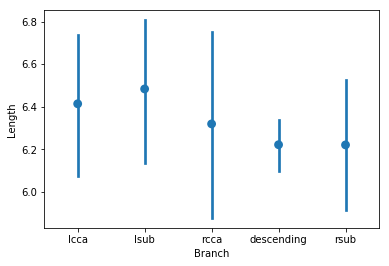

In [1101]:
sns.pointplot(x="Branch", y="Length", data=data, join=False)

The majority of released clots went through the 'Descending' branch. 
These were also the smallest clots.


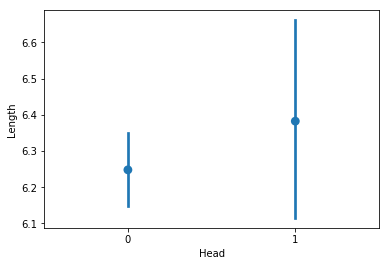

In [1102]:
sns.pointplot(x="Head", y="Length", data=data, join=False)

The longest clots (on average) went to the head. This suggests that the clot length might be a risk factor for strokes.

In [1103]:
classw = data['Head'].value_counts(normalize=True)
print('Class weights:\n {}'.format(classw))

Class weights:
 0    0.870769
1    0.129231
Name: Head, dtype: float64


13% of all clots go into head, 87% elsewehere.

### Diameter

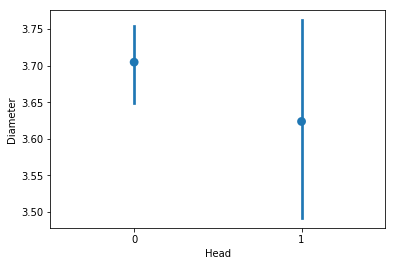

In [1104]:
sns.pointplot(x="Head", y="Diameter", data=data, join=False)

Clots of various diameter go to the head, however very large diameter does not seem to go to the head. 

[Text(0,0.5,'Diameter'),
 Text(0.5,0,'Length'),
 Text(0.5,1,'Lenght vs Diameter')]

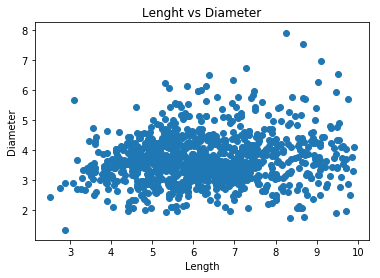

In [1105]:
fig, axes = plt.subplots()
axes.scatter(data.Length, data.Diameter)
axes.set(xlabel="Length", 
         ylabel="Diameter",
         title="Lenght vs Diameter")
# fig.savefig('fig.png', dpi=200)

### Flowrate

Blood flow refers to the movement of blood through a vessel, tissue, or organ, and is usually expressed in terms of volume of blood per unit of time. 

Types of the blood flowrates considered are:


In [1106]:
data.Flowrate.unique()

array(['steady', 'normal', 'af'], dtype=object)

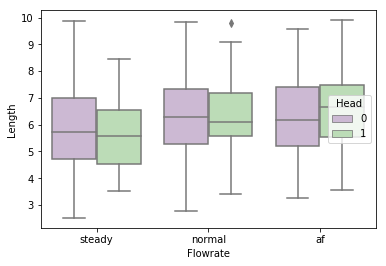

In [1107]:
sns.boxplot(x="Flowrate", y="Length", hue="Head", data=data, palette="PRGn")

Longer clots are more likely to get into the head with AF.

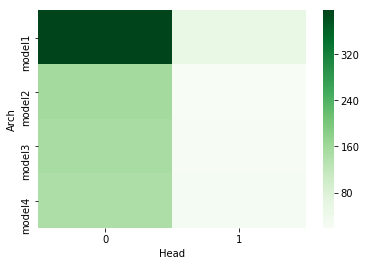

In [1108]:
z = pd.crosstab(data['Arch'], 
            data['Head'], 
           # margins=True
           )
sns.heatmap(z, cmap="Greens")

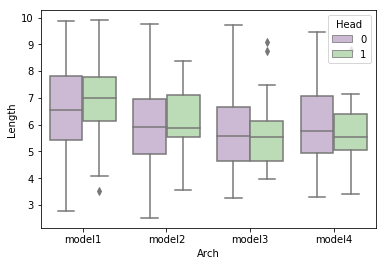

In [1109]:
sns.boxplot(x="Arch", y="Length", hue="Head", data=data, palette="PRGn")

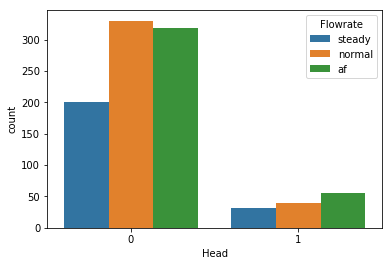

In [1110]:
sns.countplot(x='Head', data=data, hue='Flowrate')

AF seem to be a contributing factor for strokes. 

In [1111]:
data.groupby(['Flowrate'])[cols].describe(percentiles=[])

Length                                      
          count      mean       std   min   50%   max
Flowrate                                             
af        373.0  6.390134  1.510968  3.26  6.23  9.90
normal    370.0  6.393297  1.525586  2.77  6.27  9.85
steady    232.0  5.860772  1.554249  2.52  5.67  9.88

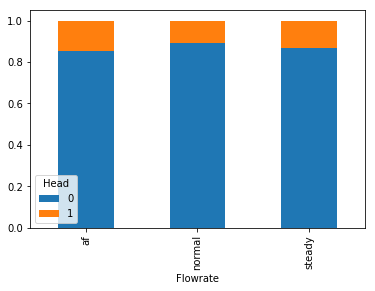

In [1112]:
table = pd.crosstab(data['Flowrate'], data['Head'], margins=False)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

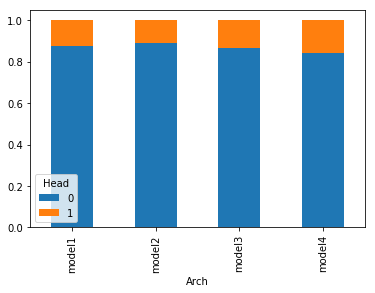

In [1113]:
table = pd.crosstab(data['Arch'], data['Head'], margins=False)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

## Classification algorithms

- Logistic regression
- CatBoost

## Logistic Regression Classifier (logit)

A machine learning classification algorithm that is used to predict the probability of a categorical dependent variable, given a set of independent variables.

This technique provides solution to the classification problem that assumes that a linear combination of the observed features and some problem-specific parameters can be used to determine the probability of each particular outcome of the dependent variable. 

## Logistic Regression Assumptions:

- Binary logistic regression requires the dependent variable to be binary;
- For a binary regression, the factor level 1 of the dependent variable should represent the outcome of interest;
- Only the meaningful variables should be included;
- The independent variables should be independent of each other (no multicollinearity);
- Logistic regression requires quite large sample sizes



## Get dummy variables (one-hot encoding)

Drop first value to avoid milticollinearity problem


In [1114]:
Arch = pd.get_dummies(data['Arch'], drop_first=True)
Flowrate = pd.get_dummies(data['Flowrate'], drop_first=True)
Entry = pd.get_dummies(data['Entry'], drop_first=True)

# collect all features
dataenc = pd.concat([data.Length, data.Diameter, data.Rigid, Arch, Flowrate, Entry], axis=1)

dataenc.columns

Index(['Length', 'Diameter', 'Rigid', 'model2', 'model3', 'model4', 'normal',
       'steady', 'left', 'right'],
      dtype='object')

In [1115]:
y = data.Head.ravel()
X = dataenc

## Scikit-learn implementation

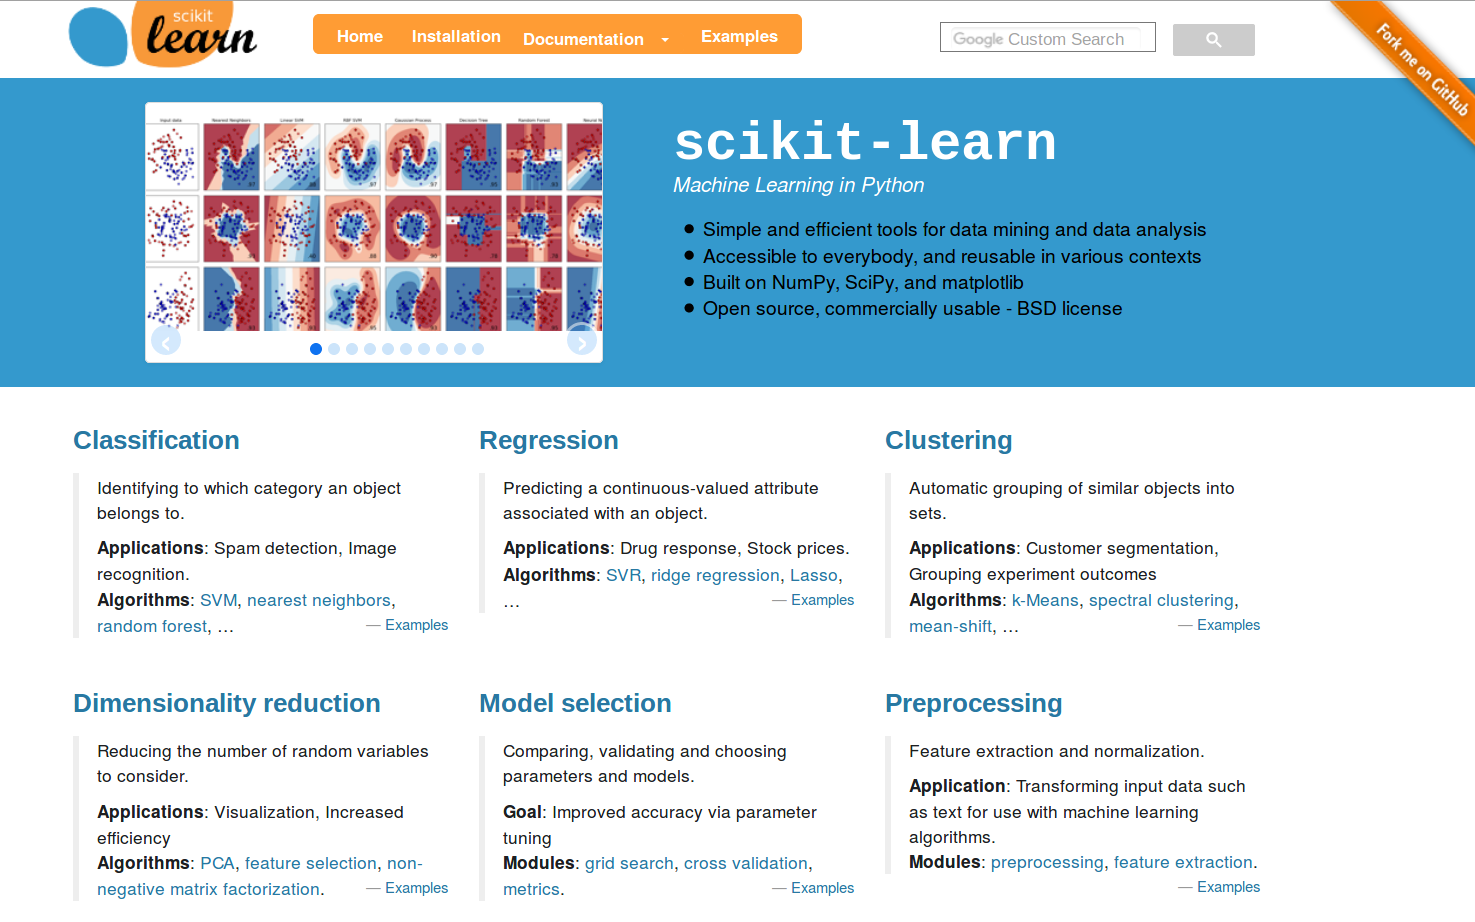

In [1116]:
Image(filename='../figs/scikit-learn.png', width = 800, height=600)

In [1117]:
print(sklearn.__doc__)
print('The scikit-learn version is {}.'.format(sklearn.__version__))


Machine learning module for Python

sklearn is a Python module integrating classical machine
learning algorithms in the tightly-knit world of scientific Python
packages (numpy, scipy, matplotlib).

It aims to provide simple and efficient solutions to learning problems
that are accessible to everybody and reusable in various contexts:
machine-learning as a versatile tool for science and engineering.

See http://scikit-learn.org for complete documentation.

The scikit-learn version is 0.19.1.


## Train-Test split

We set aside 30% of the data for testing.

In [1118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

print('X_train:', X_train.shape, "\n"
     'X_test:', X_test.shape,"\n"
      "y_train:", y_train.shape, "\n"
      "y_test:", y_test.shape, "\n")

X_train: (682, 10) 
X_test: (293, 10) 
y_train: (682,) 
y_test: (293,) 



## Model specification

In [1119]:
# We instatiate model.
# There is no way to switch off regularization in scikit-learn, 
# but we can make it ineffective by setting the tuning parameter C to a large number. 

In [1120]:
lreg2 = linear_model.LogisticRegression(penalty='l2',
                                        fit_intercept=True,
                                        class_weight='balanced',
                                        C=1e9, # smaller value stronger regularisation  
                                        random_state=13,
                                        solver='lbfgs', # algorithm to use for the optimisation problem
                                        verbose=True,
                                        max_iter=1000)

Class weight 'balanced' uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data.


## Model fit

In [1121]:
lreg2.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(C=1000000000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=13,
          solver='lbfgs', tol=0.0001, verbose=True, warm_start=False)

## Feature importance

Text(0.5,1,'Logit coefficients')

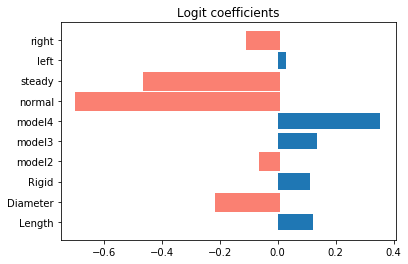

In [1122]:
lreg2_coeff = pd.DataFrame(list(zip(X_train.columns, np.transpose(lreg2.coef_).round(decimals=4))), 
                           columns=['Feature','Coefficient'])
fig, axes = plt.subplots()
hbars = axes.barh(lreg2_coeff['Feature'], lreg2_coeff['Coefficient'])
for bar, height in zip(hbars, lreg2_coeff['Coefficient']):
    if height < 0:
        bar.set(edgecolor='darkred', color='salmon', linewidth=3)
axes.set_title('Logit coefficients')

- Negative coefficients correspond to a decrease in likelihood of having a positive outcome (head 1). 
- Positive coefficient corresponds to an increase in likelihood of having a positive outcome. 

Model 4, 3 and Length increase the likelihood of outcome (head = 1). Since all heart rates (normal and steady) are negative, it means  the highest likelihood of blood clot going into the head corresponds to the baseline flowrate (AF).

## Classification report

In [1123]:
from sklearn.metrics import classification_report
print('Classification report: \n', classification_report(y_test, lreg2.predict(X_test)))

Classification report: 
              precision    recall  f1-score   support

          0       0.85      0.51      0.64       255
          1       0.11      0.39      0.17        38

avg / total       0.75      0.50      0.58       293



In [1124]:
print("Test accuracy {:.3f}".format(metrics.accuracy_score(y_test, lreg2.predict(X_test))))
print("Precision {:.3f}".format(metrics.precision_score(y_test, lreg2.predict(X_test))))
print("Recall {:.3f}".format(metrics.recall_score(y_test, lreg2.predict(X_test))))

Test accuracy 0.498
Precision 0.108
Recall 0.395


- The precision is the ability of the classifier not to label a sample as positive if it is negative.
- The recall is  the ability of the classifier to find all the positive samples.


## Confusion matrix

In [1125]:
# to describe perfprmance of classification model we use confusion matrix
# confusion matrix cas 2x2 dimensions, because it is a binaryclassification.
# Non-diagonal element are innacurate predictions

Text(0.5,257.44,'Predicted label')

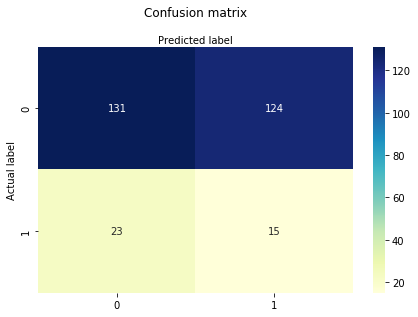

In [1126]:
cnf_matrix = metrics.confusion_matrix(y_test, lreg2.predict(X_test))
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1); plt.ylabel('Actual label'); plt.xlabel('Predicted label')

In [1127]:
len(y_test)

293

- A total of 293 predictions
- True negatives: 131, true positives: 15
- False negatives: 23, false positives: 124

FP 124 is not as bad --> precautionary principle,
worse when there is a risk for stroke, but model does not predict (FN 23).


## Cross Validation

Cross validation optimizes logistic regression on accuracy score and attempts to avoid overfitting while still producing a prediction for each observation dataset. We are using 10-fold Cross-Validation to train our model.

In [1128]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

kfold = model_selection.KFold(n_splits=10, random_state=13)
results = model_selection.cross_val_score(lreg2, X_train, y_train, cv=kfold, scoring='accuracy')

print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.535


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


The average accuracy remains very close to the Logistic Regression model accuracy; hence, we can conclude that our model generalizes well.

## ROC curve

In a ROC curve the TP rate (Sensitivity) is plotted as function of the FP rate (100-Specificity) for different cut-off points of a parameter. The area under the ROC curve (AUC) is a measure of how well a parameter can distinguish between two outcomes Stroke/No Stroke.


In [1129]:
# Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. 
# It shows the tradeoff between sensitivity and specificity.

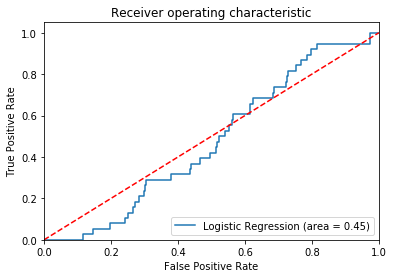

In [1130]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

lreg2_roc_auc = roc_auc_score(y_test, lreg2.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lreg2.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' %lreg2_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

## Conclusions:

- Logistic Regression is not a very accurate classifier 
- It is vulnerable to overfitting
- Does not perform well with independent variables that are not correlated to the target variable
- What can be done to improve logistic regression model? 
- Try some regularisation techniques or other classifies (incl non-linear models)
- Useful as the baseline for other binary classification algorithms
- It is not able to handle a large number of categorical features
 

## CatBoost

A fast, scalable, high performance open-source Gradient Boosting on Decision Trees library, used for ranking, classification, regression and other machine learning tasks. Supports computation on CPU and GPU. Developed by Yandex researchers and engineers, it can be applied across a wide range of areas and to a variety of problems.


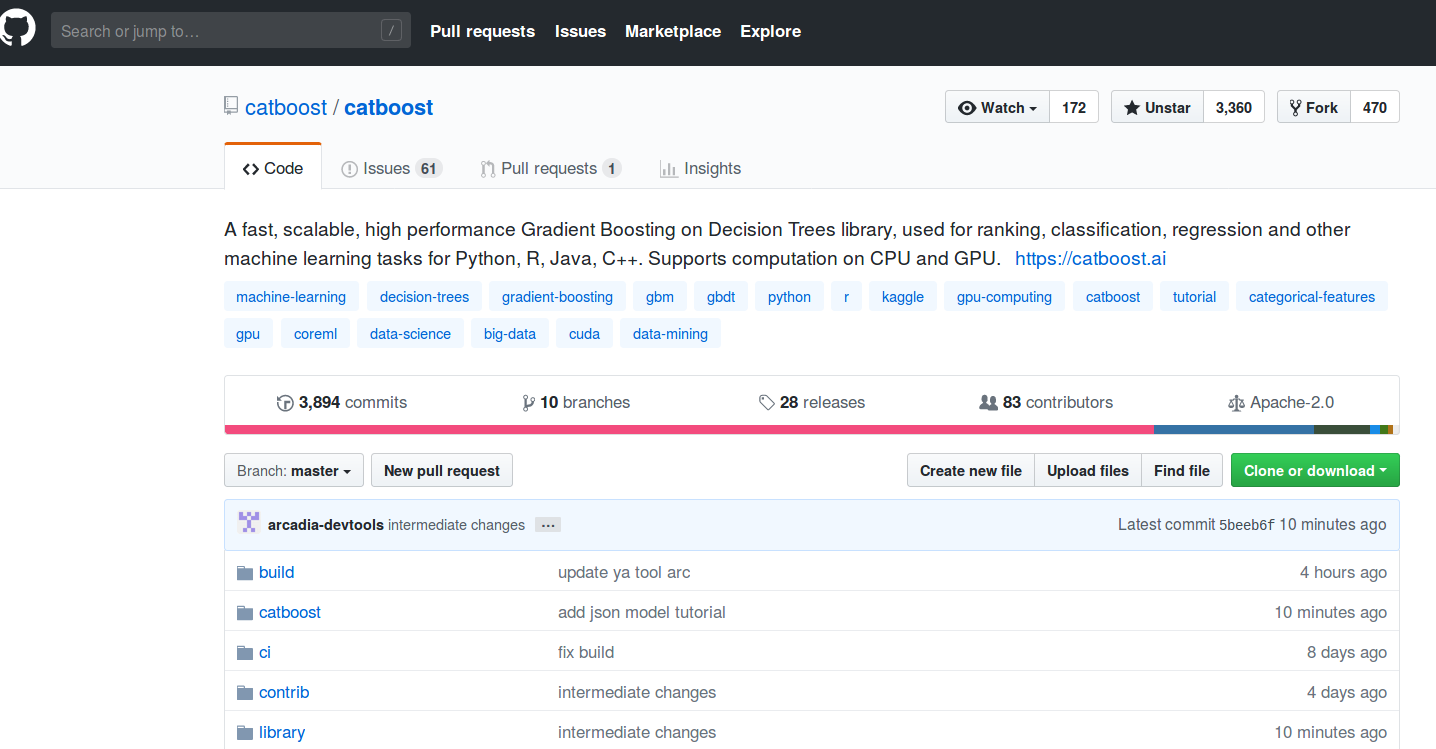

In [1131]:
Image(filename='../figs/catboost.png', width = 800, height=600)


### Features
- Categorical feature support
- Fast and scalable GPU version
- Improved accuracy
- Fast prediction
- User-friendly API interface


It works well for small and heterogeneous data.


In [1132]:
data = pd.read_csv('~/Documents/bloodclots/data/data.csv', index_col=0)

data['Head'] = data.Branch.map({'lcca':1, 
                        'rcca':1, 
                        'lsub':0, 
                        'rsub':0,
                        'descending':0
                       })
data = data[data.Length<10]

# recode rigid
data['Rigid'] = data.Rigid.map({1:'yes', 0:'no'})

y = data['Head'].ravel()
X = data.drop(['Branch', 'Head'], axis=1)

In [1133]:
X.head()


,Thrombin,Diameter,Length,Arch,Rigid,Entry,Flowrate
0,0nihu,3.74,8.47,model1,yes,right,steady
1,0nihu,4.71,6.22,model1,yes,right,steady
2,0nihu,3.42,5.57,model1,yes,right,steady
3,0nihu,3.36,5.12,model1,yes,right,steady
4,0nihu,4.29,3.61,model1,yes,right,steady


In [1134]:
# select categorical indices
categorical_features_indices = np.where(X.dtypes != np.float)[0]
categorical_features_indices

array([0, 3, 4, 5, 6])

## Train-Test-Validation Split

In [1135]:
# split data into test, train, val set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, 
                                                                y_train, 
                                                                test_size=0.30, 
                                                                random_state=13)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_validation:", X_validation.shape)

X_train: (477, 7)
X_test: (293, 7)
X_validation: (205, 7)


## Model specification

In [1136]:
params = {
    'iterations': 100,
    'learning_rate': 0.03,
    'eval_metric': 'Accuracy',
    'random_seed': 13,
    'logging_level': 'Silent',
    'use_best_model': False,
    'class_weights': classw
}

model = CatBoostClassifier(**params)

## Model fit

In [1137]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
#     logging_level='Verbose',  
    plot=False
);


print('Test accuracy: {:.3}'.format(metrics.accuracy_score(y_test, model.predict(X_test))))


Test accuracy: 0.87


## Model application

Fit model using Pool.

In [1138]:
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_validation, y_validation, cat_features=categorical_features_indices)

model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool)

print('Validation accuracy: {:.3}'.format(metrics.accuracy_score(y_validation, model.predict(X_validation))))


Validation accuracy: 0.912


## Feature Importance

In [1139]:
feature_importances = model.get_feature_importance(train_pool, prettified=False)

feature_names = X_train.columns

for score, name in sorted(zip(np.round(feature_importances, decimals=3), feature_names), 
                          reverse=True):
    print('{}: {}'.format(name, score))



Diameter: 37.422
Length: 31.507
Thrombin: 12.397
Rigid: 7.251
Entry: 6.767
Flowrate: 4.651
Arch: 0.005


Features Length and Diameter have the highest importance.

## Feature Importance Interaction

In [1140]:
feature_importances_interaction = model.get_feature_importance(train_pool, 
                                                               prettified=True, 
                                                               fstr_type='Interaction')
feature_importances_interaction[0:3]

[[1, 2, 48.15591413473442],
 [1, 5, 8.367127204019576],
 [2, 6, 5.724517418269773]]

In [1141]:
list(zip(range(len(feature_names)), feature_names))

[(0, 'Thrombin'),
 (1, 'Diameter'),
 (2, 'Length'),
 (3, 'Arch'),
 (4, 'Rigid'),
 (5, 'Entry'),
 (6, 'Flowrate')]

## Classification Report

Recall (Sensitivity): TP/actual yes --> 
Specificity: TN/actual NO -->0/43

In [1142]:
print('Classification report: \n', metrics.classification_report(y_test, model.predict(X_test)))

Classification report: 
              precision    recall  f1-score   support

          0       0.87      1.00      0.93       255
          1       0.00      0.00      0.00        38

avg / total       0.76      0.87      0.81       293



In [1143]:
print("Test accuracy {:.3f}".format(metrics.accuracy_score(y_test, model.predict(X_test))))
print("Precision {:.3f}".format(metrics.precision_score(y_test, model.predict(X_test))))
print("Recall {:.3f}".format(metrics.recall_score(y_test, model.predict(X_test))))

Test accuracy 0.870
Precision 0.000
Recall 0.000


- The precision is the ability of the classifier not to label a sample as positive if it is negative.
- The recall is  the ability of the classifier to find all the positive samples.


## Confusion Matrix

Text(0.5,257.44,'Predicted label')

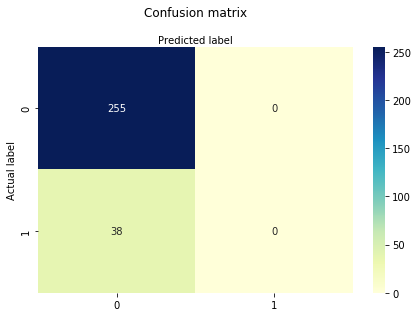

In [1147]:
cnf_matrix = metrics.confusion_matrix(y_test, model.predict(X_test))
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1); plt.ylabel('Actual label'); plt.xlabel('Predicted label')

In [1145]:
len(y_test)

293

- A total of 351 predictions
- True negatives: 308, true positives: 0
- False negatives: 43, false positives: 0

- Model fails to predict positives. It is only good at predicting no stroke.
- FP 0 are good, but FN 43 is bad; if there is a risk for stroke, model does not predict it.

## ROC 

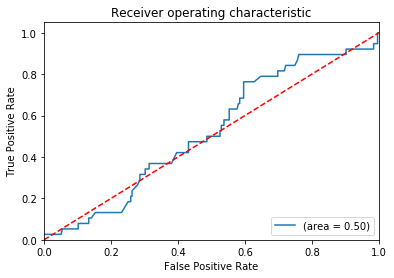

In [1149]:
model_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='(area = %0.2f)' % model_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

## Comparing Logit and CatBoost

- Improved accuracy in CatBoost (0.87) compared to Logit (0.49)
- CatBoost TN 308 vs Logit TN 131
- Precision in Logit is 0.11, CatBoost 0.00
- Recall in Logit is 0.35, CatBoost 0.00
- CatBoost FN 38 vs Logit FN 23
- CatBoost fails to predict positive classes.

## Risk factors for strokes:

- Clot size (Diameter, Length) seem to be the most importans risk factors
- There is a high degree of interaction between Diameter and Length
- In particular, clot Length increases the likelihood of having a stroke, whereas clot Diameter decreases the likelihood.
- Normal flowrate decreases the likelihood of having a stroke
- Artrial Fibrillation increases the likelihood of having a stroke.
- Model 4 (pointy shape), increases the likelihood of stroke.

## Where from here?

- Despite all shortcomings still usefull insights
- Do more model checks
- Do more model tuning
- Try different classification algorithms

## Thank you for your attention
## Any questions?


<img src="met.png">